# Additional diagnostic plots
Created by Ivan Lima on Sun Apr 11 2021 13:41:20 -0400

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, warnings
from matplotlib import ticker
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Fri May 14 09:20:50 2021


In [2]:
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 25
sns.set_theme()
sns.set_context('paper')
sns.set_palette('tab10')
plt.rcParams['figure.dpi'] = 100

## Read data

In [3]:
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string', 'award_type':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)
awards['year'] = awards.StartDate.dt.year
awards.loc[awards.program=='DATA NOT AVAILABLE','program'] = np.nan
awards['co-PI_female_pct'] = awards['co-PI_female_frac'] * 100

periods = np.array([[y,]*3 for y in range(1989,2021,3)]).flatten() # 3-year periods
years = np.arange(1987,2020)
year_to_period = {y:p for y,p in zip(years,periods)}
awards['period'] = awards.year.map(year_to_period) # map year to period

npzfile = np.load('results/NMF_TSNE.npz')
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
npzfile.close()

# Read geosciences/atmospheric/ocean sciences academic gender workforce data
workforce = pd.read_csv('data/nsf_workforce.csv')#, index_col=0)
workforce['female_frac'] = workforce.female/workforce.total
workforce['female_pct'] = workforce['female_frac'] * 100
workforce = workforce.set_index('year')

## Top 10 programs

In [4]:
top10_programs = pd.DataFrame({'number of awards':
                               awards.groupby('program')['Abstract'].count().sort_values(ascending=False)[:10]})
top10_programs['percentage of total'] = top10_programs['number of awards'] / len(awards) * 100
top10_programs['cum percentage of total'] = top10_programs['percentage of total'].cumsum() 
top10_programs

,number of awards,percentage of total,cum percentage of total
program,,,
MARINE GEOLOGY AND GEOPHYSICS,2577,22.383393,22.383393
BIOLOGICAL OCEANOGRAPHY,2121,18.422653,40.806045
PHYSICAL OCEANOGRAPHY,1835,15.938504,56.744550
CHEMICAL OCEANOGRAPHY,1347,11.699818,68.444367
OCEAN TECH & INTERDISC COORDIN,475,4.125771,72.570138
OCEANOGRAPHIC INSTRUMENTATION,453,3.934683,76.504821
SHIPBOARD SCIENTIFIC SUPP EQUI,377,3.274559,79.779380
OCEAN DRILLING PROGRAM,281,2.440719,82.220099
EDUCATION/HUMAN RESOURCES,249,2.162773,84.382872


In [5]:
awards_top10 = awards[awards.program.isin(top10_programs.index)]
top10_programs_amount = pd.DataFrame({'amount awarded': awards_top10.groupby('program')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
top10_programs_amount['percentage of total'] = top10_programs_amount['amount awarded'] / awards['tot_amount_adjusted'].sum() * 100
top10_programs_amount['cum percentage of total'] = top10_programs_amount['percentage of total'].cumsum()
top10_programs_amount.style.format('${0:,.2f}', subset='amount awarded')

,amount awarded,percentage of total,cum percentage of total
program,,,
PHYSICAL OCEANOGRAPHY,"$1,733,384,196.35",13.022919,13.022919
BIOLOGICAL OCEANOGRAPHY,"$1,497,038,872.21",11.247256,24.270175
MARINE GEOLOGY AND GEOPHYSICS,"$1,305,635,469.81",9.809242,34.079417
OCEAN DRILLING PROGRAM,"$1,184,717,727.14",8.900787,42.980203
CHEMICAL OCEANOGRAPHY,"$788,216,809.37",5.921874,48.902078
OCEAN TECH & INTERDISC COORDIN,"$490,624,932.12",3.686066,52.588144
MAJOR RESEARCH INSTRUMENTATION,"$110,463,748.31",0.829914,53.418058
OCEANOGRAPHIC INSTRUMENTATION,"$110,045,199.25",0.826770,54.244828
SHIPBOARD SCIENTIFIC SUPP EQUI,"$106,250,966.82",0.798264,55.043092


### Violin plot of award size by program

Note log scale in $x$ axis. The lines inside the distribution represent the quartiles of the distribution.

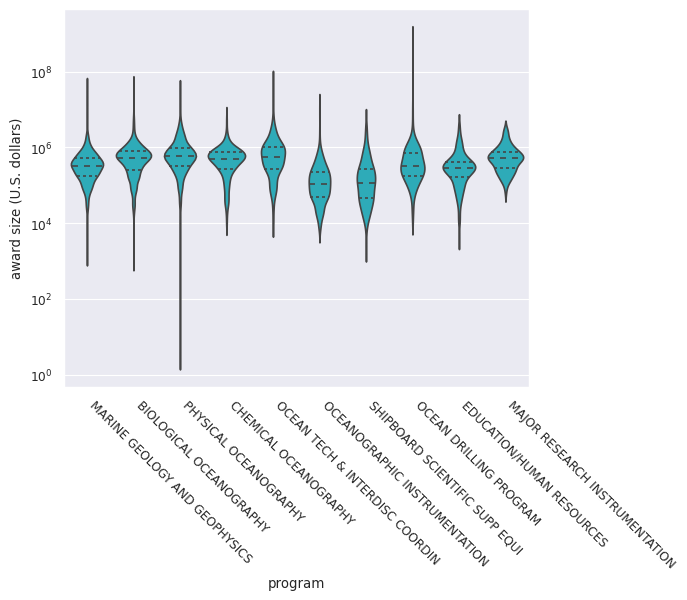

In [6]:
awards_top10['log_tot_amount_adjusted'] = np.log10(awards_top10.tot_amount_adjusted)

fig, ax = plt.subplots(figsize=(6,5))
_ = sns.violinplot(data=awards_top10, x='program', y='log_tot_amount_adjusted', showfliers=False,
                   inner='quartile', order=top10_programs.index, ax=ax, color='C9')
_ = ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Violin plot of award size by program and PI gender

Note log scale in $x$ axis. The lines inside the distribution represent the quartiles of the distribution.

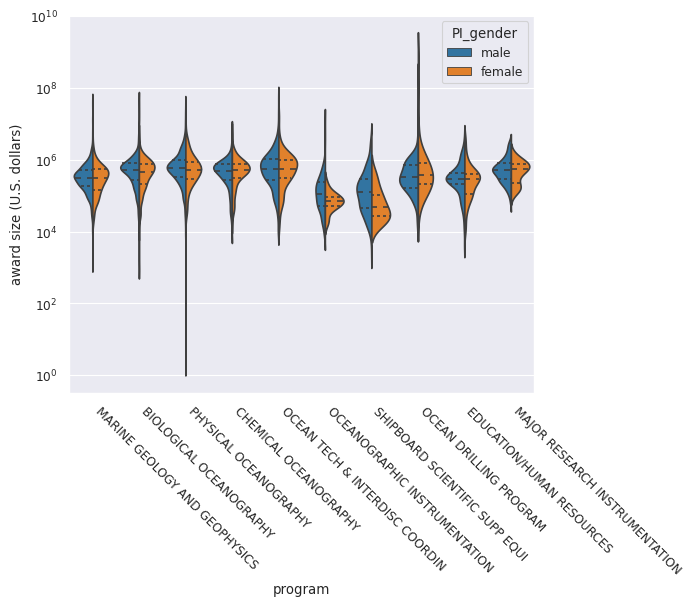

In [7]:
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.violinplot(data=awards_top10, x='program', y='log_tot_amount_adjusted', showfliers=False,
                   inner='quartile', hue='PI_gender', split=True, order=top10_programs.index, ax=ax)
_ = ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Categorical scatterplot of number of co-PIs by program

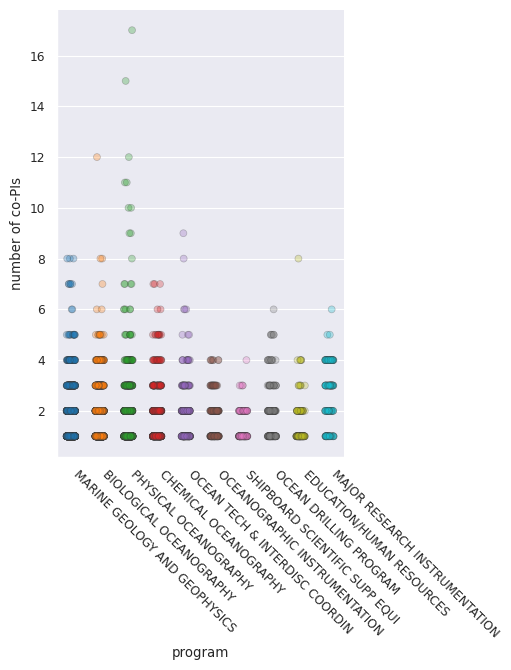

In [8]:
g = sns.catplot(data=awards_top10, x='program', y='num_co-PIs',order=top10_programs.index,
                linewidth=0.5, alpha=0.3, jitter=0.15, ax=ax)
_ = g.ax.set_ylabel('number of co-PIs')
_ = g.ax.set_xticklabels(top10_programs.index, rotation=-45, ha='left')

### Categorical scatterplot of number of co-PIs by program and PI gender

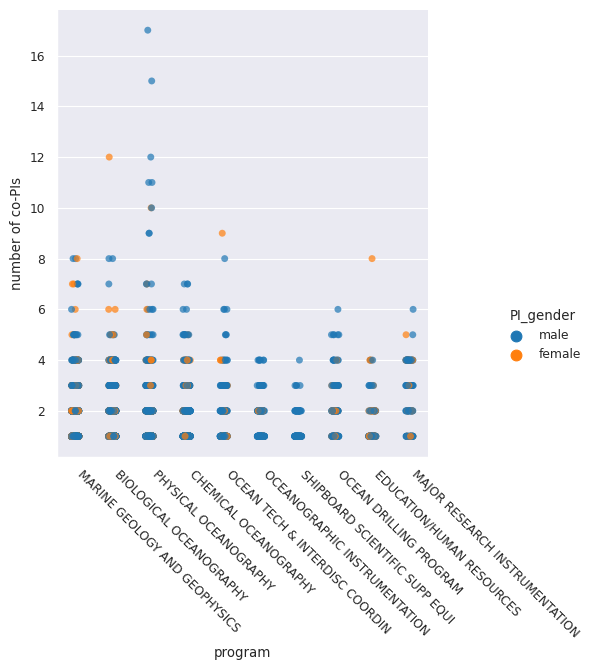

In [9]:
g = sns.catplot(data=awards_top10[awards_top10.PI_gender.notna()], x='program', y='num_co-PIs',
                order=top10_programs.index, hue='PI_gender', alpha=0.7, ax=ax)
_ = g.ax.set_ylabel('number of co-PIs')
_ = g.ax.set_xticklabels(top10_programs.index, rotation=-45, ha='left')

### Violin plot of number of co-PIs by program

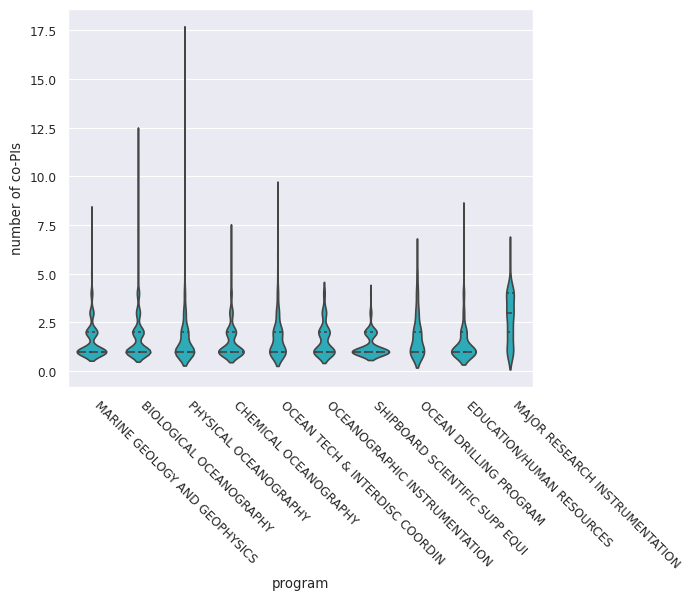

In [10]:
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.violinplot(data=awards_top10, x='program', y='num_co-PIs', showfliers=False,
                   inner='quartile', order=top10_programs.index, ax=ax, color='C9')
_ = ax.set_ylabel('number of co-PIs')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Violin plot of number of co-PIs by program and PI gender

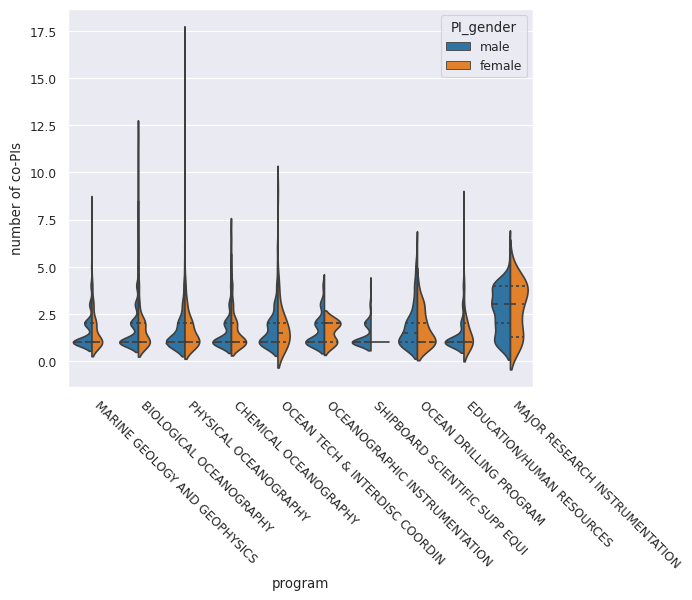

In [11]:
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.violinplot(data=awards_top10, x='program', y='num_co-PIs', showfliers=False,
                   inner='quartile', hue='PI_gender', split=True, order=top10_programs.index, ax=ax)
_ = ax.set_ylabel('number of co-PIs')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Cluster map of NSF-OCE programs

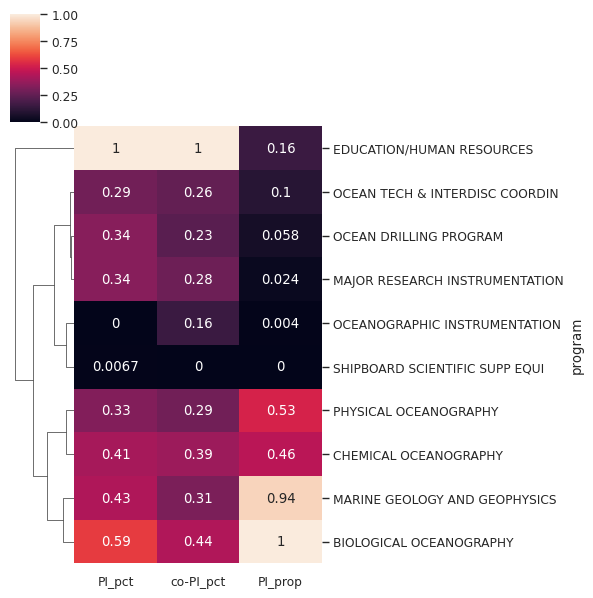

In [12]:
# awards_top10_1 = awards_top10[awards_top10.year<1998]                              # 1987-1997
# awards_top10_2 = awards_top10[(awards_top10.year>1997) & (awards_top10.year<2009)] # 1998-2008
# awards_top10_3 = awards_top10[awards_top10.year>2008]                              # 2009-2019

pi_count = awards_top10.groupby(['program','PI_gender'])['Abstract'].count().unstack()
df_pi = pi_count.div(pi_count.sum(axis=1), axis=0) * 100
df_pi_prop = pi_count.div(pi_count.sum(axis=0), axis=1) * 100
df_copi = awards_top10.groupby('program')['co-PI_female_frac'].mean() * 100

# df_program = pd.DataFrame({'PI_pct': df_pi.female, 'co-PI_pct': df_copi, 'PI_ratio': df_pi_prop.female/df_pi_prop.male})
df_program = pd.DataFrame({'PI_pct': df_pi.female, 'co-PI_pct': df_copi, 'PI_prop': df_pi_prop.female})
df_program = df_program.reindex(top10_programs.index)

cg = sns.clustermap(df_program, annot=True, standard_scale=1, col_cluster=False, figsize=(6,6))
cg.fig.savefig('figures/cluster_program.png', dpi=300, bbox_inches='tight')

## Research topics

### Violin plot of number of co-PIs by research topic

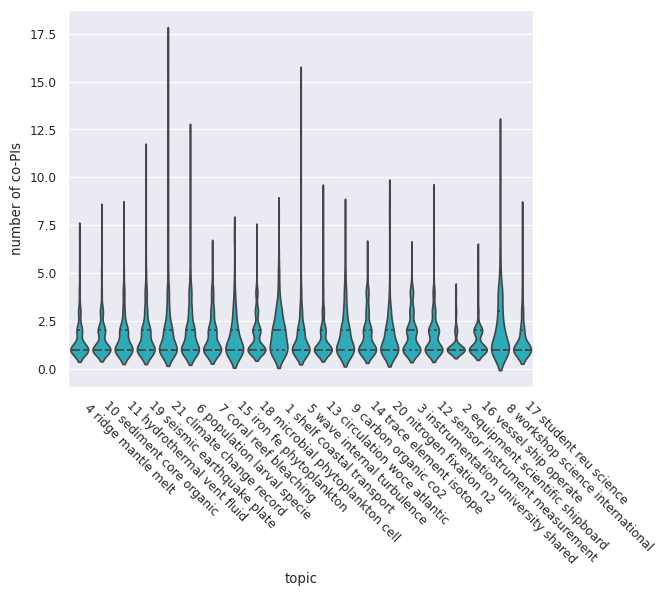

In [13]:
topic_order = np.array([4,10,11,19,21,6,7,15,18,1,5,13,9,14,20,3,12,2,16,8,17]) # order topics by program
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.violinplot(data=awards, x='topic', y='num_co-PIs', showfliers=False, orient='v',
                   inner='quartile', order=topic_order, scale='width', ax=ax, color='C9')
_ = ax.set(xticklabels=topic_names_r[topic_order-1])
_ = ax.set_ylabel('number of co-PIs')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Violin plot of number of co-PIs by research topic and PI gender

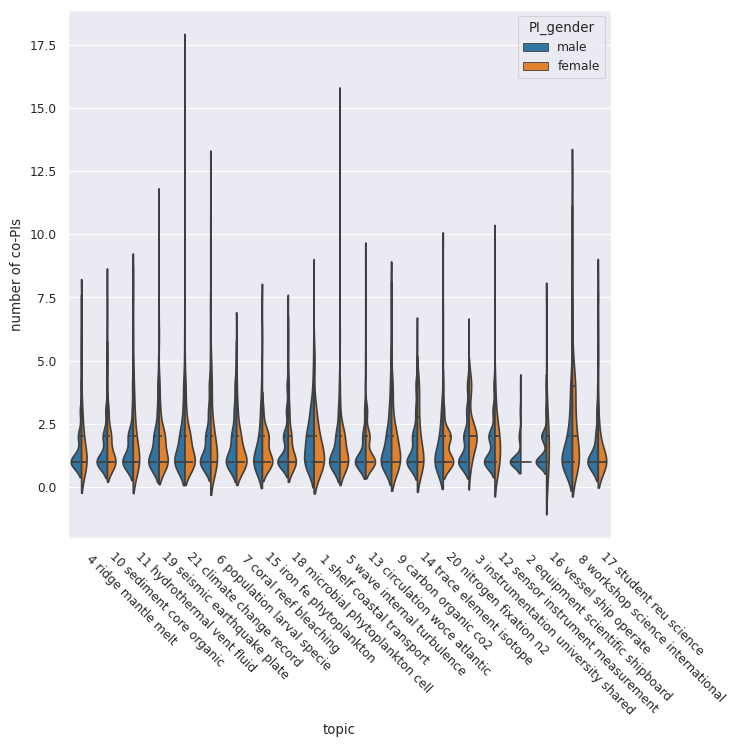

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.violinplot(data=awards, x='topic', y='num_co-PIs', showfliers=False, orient='v',
                   inner='quartile', order=topic_order, hue='PI_gender', split=True, ax=ax)
_ = ax.set(xticklabels=topic_names_r[topic_order-1])
_ = ax.set_ylabel('number of co-PIs')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Categorical scatterplot of number of co-PIs by research topic

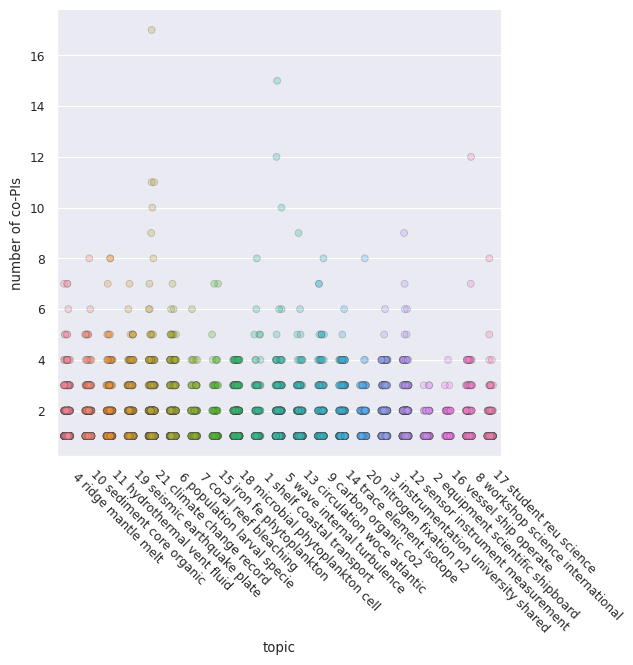

In [15]:
g = sns.catplot(data=awards_top10, x='topic', y='num_co-PIs',order=topic_order,
                linewidth=0.5, alpha=0.3, jitter=0.15, ax=ax)
_ = g.ax.set_ylabel('number of co-PIs')
_ = g.ax.set_xticklabels(topic_names_r[topic_order-1], rotation=-45, ha='left')

### Cluster map of NSF-OCE topics

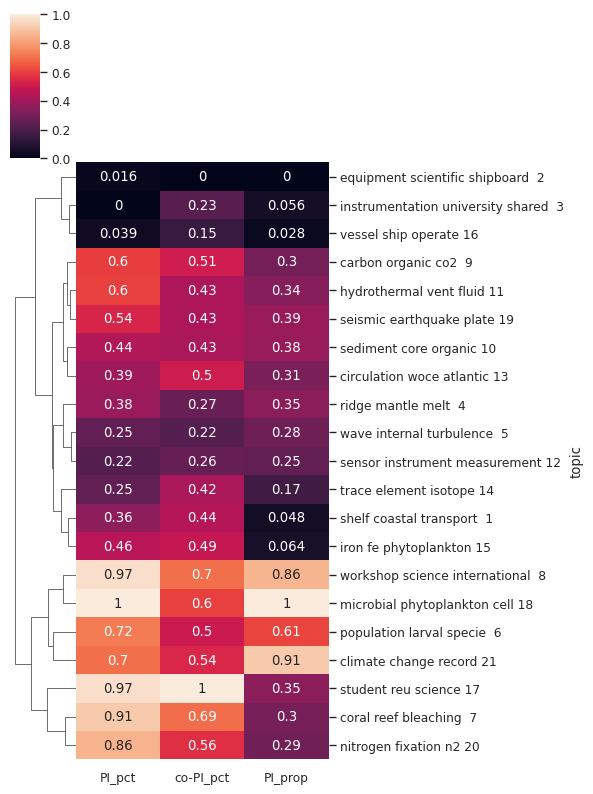

In [16]:
topic_map = {t+1:topic_names[t] for t in range(len(topic_names))}

pi_count = awards.groupby(['topic','PI_gender'])['Abstract'].count().unstack()
df_pi = pi_count.div(pi_count.sum(axis=1), axis=0) * 100
df_pi_prop = pi_count.div(pi_count.sum(axis=0), axis=1) * 100
df_copi = awards.groupby('topic')['co-PI_female_frac'].mean() * 100

# df_topic = pd.DataFrame({'PI_pct': df_pi.female, 'co-PI_pct': df_copi, 'PI_ratio': df_pi_prop.female/df_pi_prop.male})
df_topic = pd.DataFrame({'PI_pct': df_pi.female, 'co-PI_pct': df_copi, 'PI_prop': df_pi_prop.female})
df_topic.index = df_topic.index.map(topic_map)

cg = sns.clustermap(df_topic, annot=True, standard_scale=1, col_cluster=False, figsize=(6,8))
cg.fig.savefig('figures/cluster_topic.png', dpi=300, bbox_inches='tight')

## Award types

In [17]:
awards_clean = awards[awards.award_type!='POWRE']
awards_clean = awards_clean[awards_clean.award_type!='CMG']
atypes = pd.DataFrame({'number of awards': awards_clean.award_type.value_counts()})
atypes['percentage of total'] =  atypes['number of awards'] / len(awards) * 100
atypes['cum percentage of total'] = atypes['percentage of total'].cumsum()

### Violin plot of award size by award type

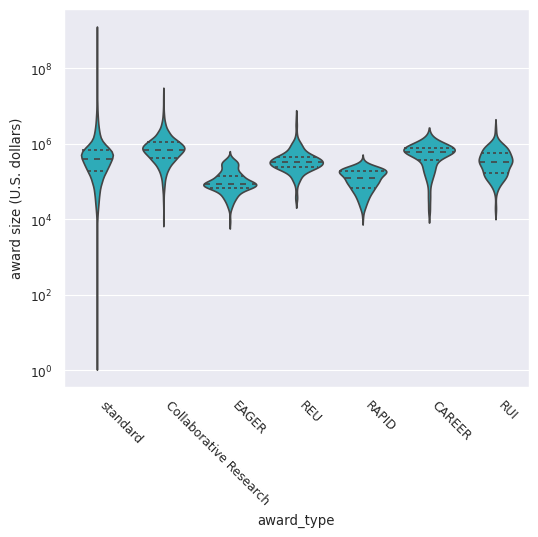

In [18]:
awards_clean['log_tot_amount_adjusted'] = np.log10(awards_clean.tot_amount_adjusted)
awards_clean.loc[np.isinf(awards_clean.log_tot_amount_adjusted), 'log_tot_amount_adjusted'] = np.nan
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.violinplot(data=awards_clean, x='award_type', y='log_tot_amount_adjusted', showfliers=False,
                   inner='quartile', order=atypes.index, ax=ax, color='C9')
_ = ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Violin plot of award size by award type and PI gender

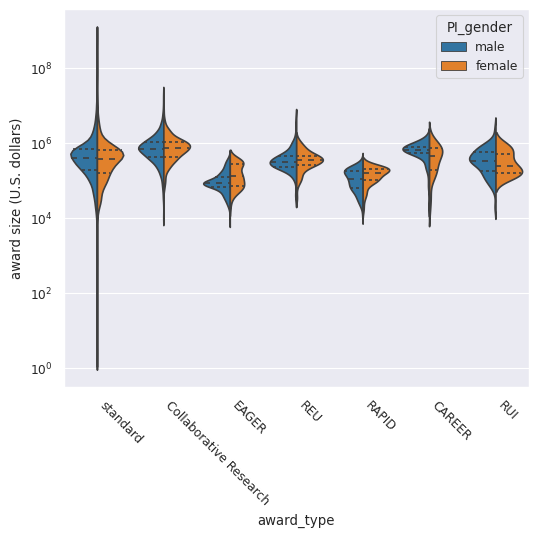

In [19]:
awards_clean['log_tot_amount_adjusted'] = np.log10(awards_clean.tot_amount_adjusted)
awards_clean.loc[np.isinf(awards_clean.log_tot_amount_adjusted), 'log_tot_amount_adjusted'] = np.nan
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.violinplot(data=awards_clean, x='award_type', y='log_tot_amount_adjusted', showfliers=False,
                   inner='quartile', order=atypes.index, hue='PI_gender', split=True, ax=ax,)
_ = ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Categorical scatterplot of number of co-PIs by award type

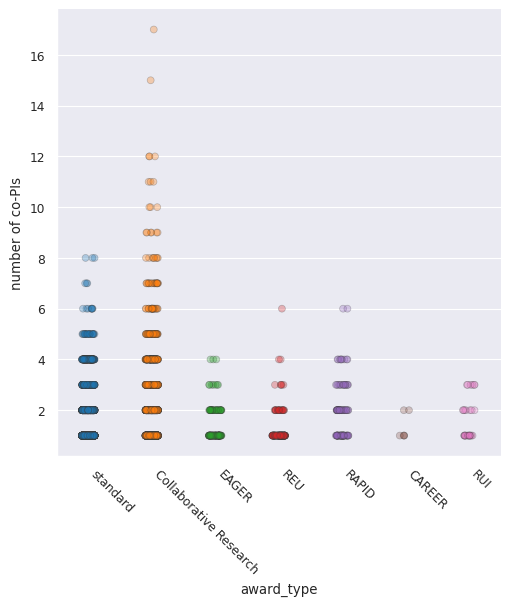

In [20]:
g = sns.catplot(data=awards_clean, x='award_type', y='num_co-PIs', order=atypes.index,
                linewidth=0.5, alpha=0.3, ax=ax)
_ = g.ax.set_ylabel('number of co-PIs')
_ = g.ax.set_xticklabels(atypes.index, rotation=-45, ha='left')

### Categorical scatterplot of number of co-PIs by award type and PI gender

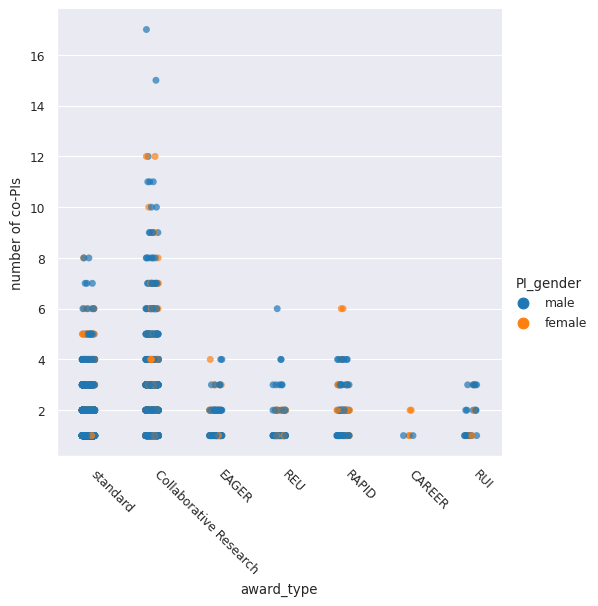

In [21]:
g = sns.catplot(data=awards_clean[awards_clean.PI_gender.notna()], x='award_type', y='num_co-PIs',
                order=atypes.index, alpha=0.7, hue='PI_gender', ax=ax)
_ = g.ax.set_ylabel('number of co-PIs')
_ = g.ax.set_xticklabels(atypes.index, rotation=-45, ha='left')

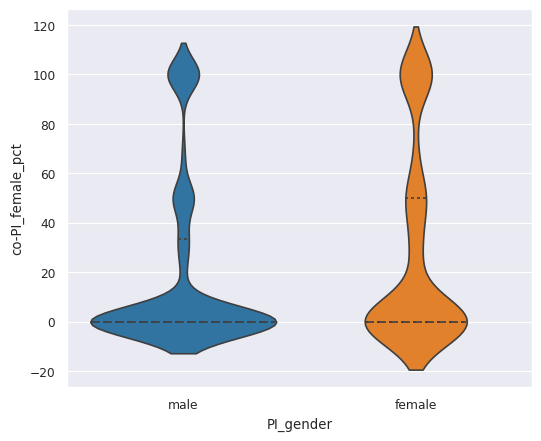

In [22]:
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.violinplot(data=awards_clean, x='PI_gender', y='co-PI_female_pct', showfliers=False,
                   inner='quartile', ax=ax,)

### Cluster map of NSF-OCE award types

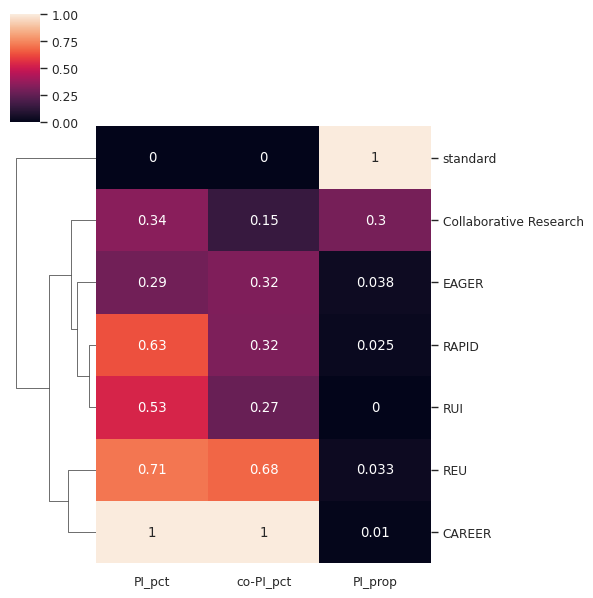

In [23]:
pi_count = awards_clean.groupby(['award_type','PI_gender'])['Abstract'].count().unstack()
df_pi = pi_count.div(pi_count.sum(axis=1), axis=0) * 100
df_pi_prop = pi_count.div(pi_count.sum(axis=0), axis=1) * 100
df_copi = awards_clean.groupby('award_type')['co-PI_female_frac'].mean() * 100

# df_atype = pd.DataFrame({'PI_pct': df_pi.female, 'co-PI_pct': df_copi, 'PI_ratio': df_pi_prop.female/df_pi_prop.male})
df_atype = pd.DataFrame({'PI_pct': df_pi.female, 'co-PI_pct': df_copi, 'PI_prop': df_pi_prop.female})
df_atype = df_atype.reindex(atypes.index)

cg = sns.clustermap(df_atype, annot=True, standard_scale=1, col_cluster=False, figsize=(6,6))
cg.fig.savefig('figures/cluster_atype.png', dpi=300, bbox_inches='tight')

## KDE plot of percentage of women co-PIs by PI gender

PI_gender
female    28.099913
male      18.917151
Name: co-PI_female_pct, dtype: float64

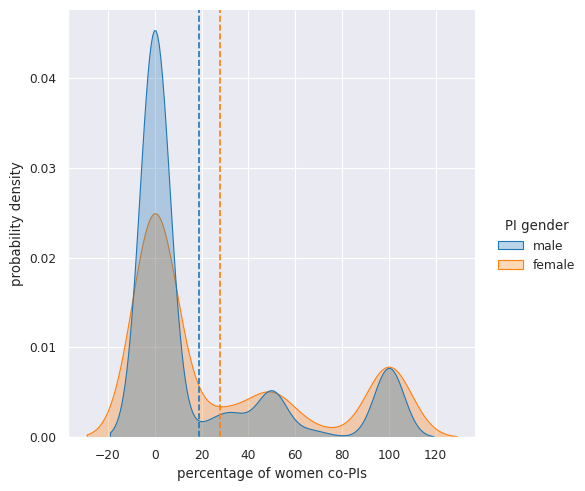

In [24]:
df = awards[awards['co-PI_female_pct'].notna()]

means = df.groupby('PI_gender')['co-PI_female_pct'].mean()
mean_men = means['male']
mean_women = means['female']

g = sns.displot(df, x='co-PI_female_pct', hue='PI_gender', common_norm=False, alpha=0.3, kind='kde', fill=True)
_ = g.ax.axvline(mean_men, c='C0', ls='--')
_ = g.ax.axvline(mean_women, c='C1', ls='--')
_ = g.set_xlabels('percentage of women co-PIs')
_ = g.set_ylabels('probability density')
_ = g.legend.set_title('PI gender')

means

## KDE plot of percentage of men co-PIs by PI gender

PI_gender
female    71.900087
male      81.082849
Name: co-PI_male_pct, dtype: float64

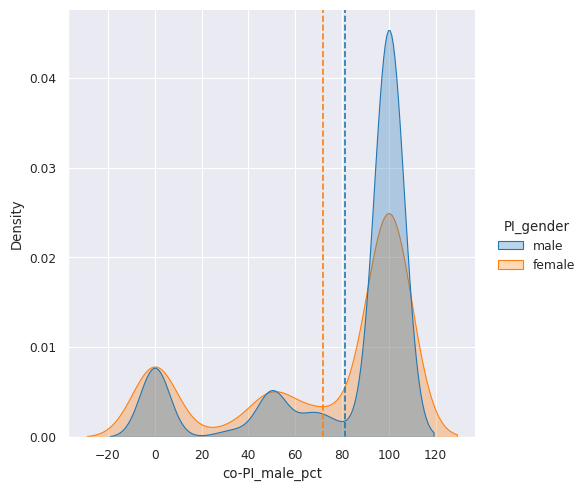

In [25]:
df['co-PI_male_pct'] = 100. - df['co-PI_female_pct']

means = df.groupby('PI_gender')['co-PI_male_pct'].mean()
mean_men = means['male']
mean_women = means['female']

g = sns.displot(df, x='co-PI_male_pct', hue='PI_gender', common_norm=False, alpha=0.3, kind='kde', fill=True)
_ = g.ax.axvline(mean_men, c='C0', ls='--')
_ = g.ax.axvline(mean_women, c='C1', ls='--')

means

## KDE plot of the number of co-PIs by PI gender

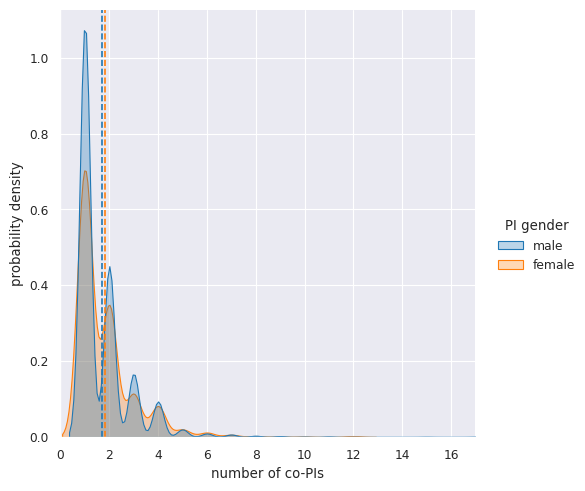

In [26]:
df = awards[awards['num_co-PIs'].notna()]

means = df.groupby('PI_gender')['num_co-PIs'].mean()
mean_men = means['male']
mean_women = means['female']

g = sns.displot(df, x='num_co-PIs', hue='PI_gender', common_norm=False, alpha=0.3, kind='kde', fill=True)
# g = sns.displot(df, x='num_co-PIs', hue='PI_gender', common_norm=False, alpha=0.3, bins=17)
# g = sns.displot(df, x='num_co-PIs', log_scale=False, hue='PI_gender', stat='density', common_norm=False, alpha=0.3, kde=True, bins=16)
_ = g.ax.axvline(mean_men, c='C0', ls='--')
_ = g.ax.axvline(mean_women, c='C1', ls='--')
_ = g.set_xlabels('number of co-PIs')
_ = g.set_ylabels('probability density')
_ = g.legend.set_title('PI gender')
_ = g.set(xlim=(0,17))